# Commonly Expressed Genes

In [130]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb
from larval_gonad.x_to_a import (CHROMS_CHR, MAJOR_ARMS_CHR, idx_stats_by_cluster, commonly_expressed)
from larval_gonad.plotting import make_figs
from larval_gonad.io import memory

# Setup notebook
nbconfig = Nb.setup_notebook('commonly_expressed_genes', subproject_dir='../output/testis_scRNAseq_pilot')

last updated: 2018-02-06 
Git hash: 7e850ace74473c472616ba961e65c769bf25d12b


In [142]:
# Import data from testes
norm = nbconfig.seurat.get_normalized_read_counts()
clusters = nbconfig.seurat.get_clusters()

# Get list of commonly expressed gene
expressed = commonly_expressed(norm)

# Import Tau and TSPS
male_tau = pd.read_csv('../output/2018-02-05_tau_male_tau.tsv', sep='\t', index_col=0)
male_tsps = pd.read_csv('../output/2018-02-05_tau_male_tsps.tsv', sep='\t', index_col=0)

# Make data table
male = male_tau.join(male_tsps)
male['expressed'] = False
male.loc[expressed, 'expressed'] = True
male['gene'] = male.index.map(lambda x: nbconfig.fbgn2symbol[x])
male.set_index('gene', append=True, inplace=True)

# Gene expressed in single cell, but not in Haiwang's data
display(Markdown('There is one gene expressed in the scRNA-seq data set that was not expressed in Haiwang\'s tissue dataset.'))
display(male[male.tau.isna() & male.expressed])

# Create bins based on tau and tsps
male.dropna(inplace=True)
tau_bins = pd.cut(male.tau, [0, .25, .5, .75, 1])
tau_bins.name = 'bins_tau'
tsps_bins = pd.cut(male.tsps, [0, .25, .5, .75, 1])
tsps_bins.name = 'bins_tsps'
male = male.join(tau_bins).join(tsps_bins)

There is one gene expressed in the scRNA-seq data set that was not expressed in Haiwang's tissue dataset.

,,tau,tsps,expressed
FBgn,gene,,,
FBgn0264478,CG43886,NaN,NaN,True


In [140]:
# Tau contingency
ct_tau = pd.crosstab(male['bins_tau'], male['expressed']).T
stat, pval, _, _ = chi2_contingency(ct_tau)
display(ct_tau)
print(f'Stat: {stat}\nPvalue: {pval}')

bins_tau,"(0.0, 0.25]","(0.25, 0.5]","(0.5, 0.75]","(0.75, 1.0]"
expressed,,,,
False,134,1217,2220,8832
True,80,893,1323,623


Stat: 2508.2930326567266
Pvalue: 0.0


In [141]:
# Tau contingency
ct_tsps = pd.crosstab(male['bins_tsps'], male['expressed']).T
stat, pval, _, _ = chi2_contingency(ct_tsps)
display(ct_tsps)
print(f'Stat: {stat}\nPvalue: {pval}')

bins_tsps,"(0.0, 0.25]","(0.25, 0.5]","(0.5, 0.75]","(0.75, 1.0]"
expressed,,,,
False,2343,1107,917,769
True,1835,650,191,105


Stat: 504.9508005630971
Pvalue: 4.034121441241576e-109


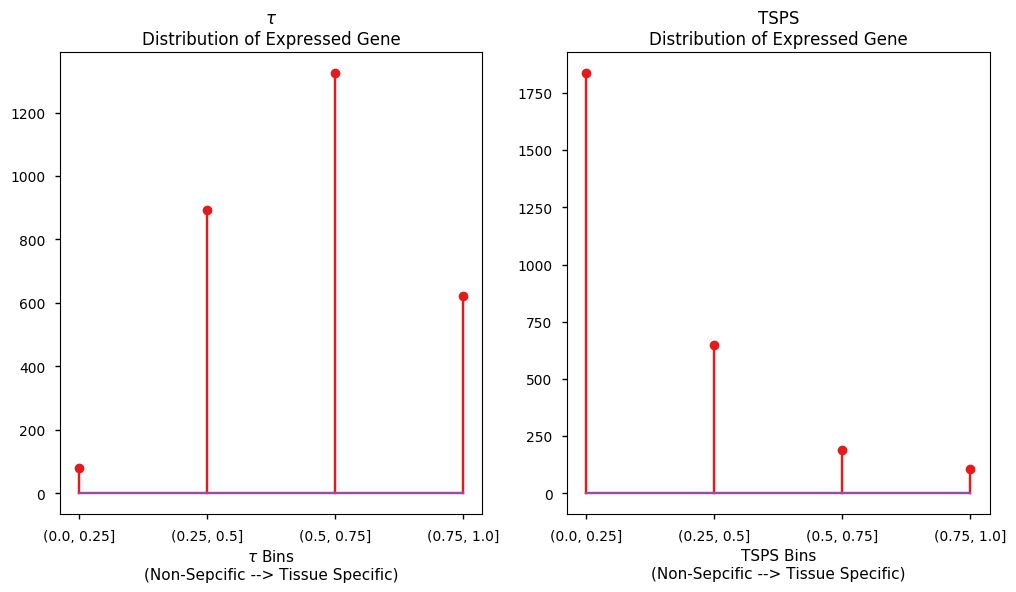

In [146]:
# Plot the gene counts by bin
def _plot():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=plt.figaspect(.5))
    ax1.stem(ct_tau.T.iloc[:, 1])
    ax1.set_title(r'$\tau$' + '\nDistribution of Expressed Gene')
    ax1.set_xticks([0, 1, 2, 3])
    ax1.set_xticklabels(['(0.0, 0.25]', '(0.25, 0.5]', '(0.5, 0.75]', '(0.75, 1.0]'])
    ax1.set_xlabel(r'$\tau$ Bins' + '\n(Non-Sepcific --> Tissue Specific)')
    ax2.stem(ct_tsps.T.iloc[:, 1])
    ax2.set_title('TSPS\nDistribution of Expressed Gene')
    ax2.set_xticks([0, 1, 2, 3])
    ax2.set_xticklabels(['(0.0, 0.25]', '(0.25, 0.5]', '(0.5, 0.75]', '(0.75, 1.0]'])
    ax2.set_xlabel('TSPS Bins\n' + r'(Non-Sepcific --> Tissue Specific)')
    
_plot()

In [173]:
display(Markdown('These genes are considered commonly expressed, but show evidence of tissue specificity with TSPS.'))
display(HTML(male[(male['bins_tsps'] == pd.Interval(0.75, 1.0)) & male['expressed']].sort_index(level=-1).to_html()))

These genes are considered commonly expressed, but show evidence of tissue specificity with TSPS.

,,tau,tsps,expressed,bins_tau,bins_tsps
FBgn,gene,,,,,
FBgn0010100,Acon,0.844042,0.780225,True,"(0.75, 1.0]","(0.75, 1.0]"
FBgn0000116,Argk,0.841782,0.808345,True,"(0.75, 1.0]","(0.75, 1.0]"
FBgn0034439,CG10062,0.759344,0.837817,True,"(0.75, 1.0]","(0.75, 1.0]"
FBgn0010620,CG10939,0.872744,0.779520,True,"(0.75, 1.0]","(0.75, 1.0]"
FBgn0040364,CG11378,0.845876,0.765679,True,"(0.75, 1.0]","(0.75, 1.0]"
FBgn0037164,CG11438,0.853610,0.785139,True,"(0.75, 1.0]","(0.75, 1.0]"
FBgn0037777,CG11722,0.882941,0.814486,True,"(0.75, 1.0]","(0.75, 1.0]"
FBgn0038577,CG12321,0.886095,0.893341,True,"(0.75, 1.0]","(0.75, 1.0]"
FBgn0031772,CG13994,0.894250,0.888042,True,"(0.75, 1.0]","(0.75, 1.0]"
